# MLP-based Model

## Softmax DNN

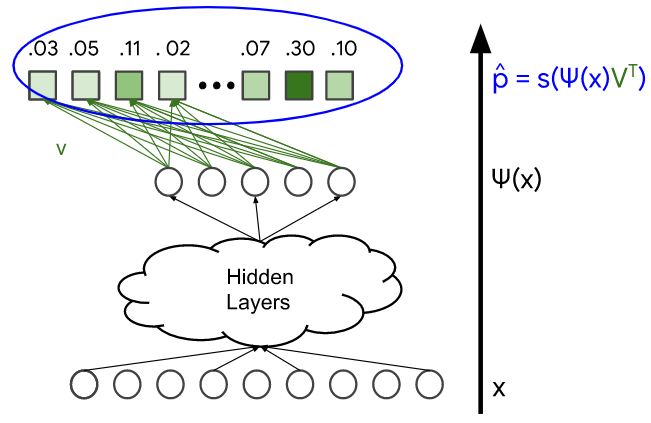

input = 행 - 영화, 열 - 영화에 대한 feature

output = 영화의 feature들을 기반으로 각 영화마다의 확률 값을 구한 임베딩을 통하여 사용자에게 유사한 영화를 추천

주의 - 만약 유저의 쿼리를 기반으로 feature를 만든다면 새로운 NN을 만들어 두 NN을 concat하여 사용해야함

In [ ]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import warnings

warnings.filterwarnings(action='ignore')

In [ ]:
movie_paths = '/content/drive/MyDrive/추천/data/movies/'

meta = pd.read_csv(movie_paths + 'movies_metadata.csv', low_memory=False).dropna(axis = 0)
meta = meta.rename(columns={'id':'movieId'})

In [ ]:
from sklearn.preprocessing import LabelEncoder
scaler = LabelEncoder()
scaler.fit(meta['original_title'].values.reshape(-1,1))
meta['target'] = scaler.transform(meta['original_title'].values.reshape(-1,1)).reshape(-1,1)

In [ ]:
cols = ['revenue', 'runtime', 'vote_average', 'vote_count']
X = meta[cols]
y = meta['target']

In [ ]:
X.head()

,revenue,runtime,vote_average,vote_count
9,352194034.0,130.0,6.6,1194.0
68,28215918.0,91.0,7.0,513.0
69,25836616.0,108.0,6.9,1644.0
153,1275000.0,83.0,6.8,28.0
178,66000000.0,92.0,5.2,153.0


In [ ]:
y.head()

9      197
68     178
69     182
153     83
178    321
Name: target, dtype: int64

In [ ]:
X = X.values

In [ ]:
y = y.values

In [ ]:
BATCH_SIZE = 128
EPOCHS = 100
num_classes = meta['target'].nunique()

In [ ]:
# 환경설정
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')
print(DEVICE)

cuda


In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomDataset(Dataset):

  # 데이터 정의
  def __init__(self, x_data, y_data = None):
    self.x_data = (x_data - x_data.min(axis = 0)) / (x_data.max(axis = 0) - x_data.min(axis = 0))
    self.y_data = y_data

  # 이 데이터 셋의 총 데이터 수
  def __len__(self):
    return len(self.x_data)

  # 어떠한 idx를 받았을 때 그에 맞는 데이터를 반환
  def __getitem__(self, idx):
    if self.y_data is None:
      x = torch.FloatTensor(self.x_data[idx])
      return x
    else:
      x = torch.FloatTensor(self.x_data[idx])
      y = torch.LongTensor(self.y_data.reshape(-1,1)[idx])[0]
      return x, y

In [ ]:
# 추천시스템의 DNN은 기존 DNN의 성능 향상을 위한 테크닉이 적용되지 않는 다는 것을 알 수 있으며 
# 추천시스템의 DNN은 기존의 신경망들과 다른 방식으로 구성하는 것이 더 좋아보임  

class MLP(nn.Module):
  def __init__(self, num_classes):
    super(MLP, self).__init__()
    self.linear1 = nn.Sequential(
        nn.Linear(4, 512),
        # nn.BatchNorm1d(512), # 제거하는 것이 더 높은 성능을 보임
        nn.ReLU()
    )
    self.linear2 = nn.Sequential(
        nn.Linear(512, 256),
        # nn.BatchNorm1d(256),
        nn.ReLU()
    )
    self.linear3 = nn.Sequential(
        nn.Linear(256, 128),
        # nn.BatchNorm1d(128),
        nn.ReLU()
    )
    self.linear4 = nn.Sequential(
        nn.Linear(128, num_classes)
    )

  def forward(self, x):
    x = self.linear1(x)
    x = self.linear2(x)
    x = self.linear3(x)
    x = self.linear4(x)
    return x

In [ ]:
def weiht_init(model):
  if isinstance(model, nn.Linear):
    torch.nn.init.kaiming_uniform_(model.weight.data)

In [ ]:
model = MLP(num_classes).to(DEVICE)
model.apply(weiht_init)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

MLP(
  (linear1): Sequential(
    (0): Linear(in_features=4, out_features=512, bias=True)
    (1): ReLU()
  )
  (linear2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
  )
  (linear3): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
  )
  (linear4): Sequential(
    (0): Linear(in_features=128, out_features=688, bias=True)
  )
)


In [ ]:
def train(model, train_loader):
  model.train()
  train_loss = 0
  correct = 0

  for X_train, y_train in train_loader:
    X_train = X_train.to(DEVICE)
    y_train = y_train.to(DEVICE)
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    prediction = output.max(1, keepdim = True)[1]
    correct += prediction.eq(y_train.view_as(prediction)).sum().item()
      
  train_loss /= len(train_loader)
  train_accuracy = 100. * correct / len(train_loader.dataset)
  return train_loss, train_accuracy

In [ ]:
def evaluate(model, train_loader):
  model.eval()
  result = []
  correct = 0

  with torch.no_grad():
    for X_train, y_train in train_loader:
      X_train = X_train.to(DEVICE)
      y_train = y_train.to(DEVICE)
      output= model(X_train)
      result.append(F.softmax(output).cpu().numpy())

      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(y_train.view_as(prediction)).sum().item()

  train_accuracy = 100. * correct / len(train_loader.dataset)
  result = np.concatenate(result)

  return result, train_accuracy

In [ ]:
train_dataset = CustomDataset(X, y)

train_loader = DataLoader(
  train_dataset,
  batch_size = BATCH_SIZE,
  shuffle = False,
  drop_last = False,
  )

for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model, train_loader)
  print(f"\n[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %")


[EPOCH: 1], 	Train Loss: 6.6707, 	Train Accuracy: 0.00 %

[EPOCH: 2], 	Train Loss: 6.5354, 	Train Accuracy: 0.00 %

[EPOCH: 3], 	Train Loss: 6.5174, 	Train Accuracy: 0.14 %

[EPOCH: 4], 	Train Loss: 6.5026, 	Train Accuracy: 0.29 %

[EPOCH: 5], 	Train Loss: 6.4792, 	Train Accuracy: 0.87 %

[EPOCH: 6], 	Train Loss: 6.4484, 	Train Accuracy: 0.72 %

[EPOCH: 7], 	Train Loss: 6.4115, 	Train Accuracy: 0.58 %

[EPOCH: 8], 	Train Loss: 6.3650, 	Train Accuracy: 0.72 %

[EPOCH: 9], 	Train Loss: 6.3127, 	Train Accuracy: 0.72 %

[EPOCH: 10], 	Train Loss: 6.2541, 	Train Accuracy: 1.01 %

[EPOCH: 11], 	Train Loss: 6.1936, 	Train Accuracy: 1.01 %

[EPOCH: 12], 	Train Loss: 6.1279, 	Train Accuracy: 1.30 %

[EPOCH: 13], 	Train Loss: 6.0566, 	Train Accuracy: 1.30 %

[EPOCH: 14], 	Train Loss: 5.9826, 	Train Accuracy: 1.44 %

[EPOCH: 15], 	Train Loss: 5.9046, 	Train Accuracy: 1.73 %

[EPOCH: 16], 	Train Loss: 5.8147, 	Train Accuracy: 2.16 %

[EPOCH: 17], 	Train Loss: 5.7242, 	Train Accuracy: 2.02 %

[EPOC

In [ ]:
result, accuracy = evaluate(model, train_loader)
result

array([[1.0767877e-18, 3.4300737e-19, 4.2245387e-26, ..., 2.1071240e-24,
        5.9889235e-36, 9.6821925e-22],
       [7.2728955e-17, 3.6710449e-07, 1.4407671e-14, ..., 3.8502356e-05,
        1.9274886e-07, 6.9426460e-04],
       [2.2937906e-25, 9.3925911e-14, 7.8212972e-21, ..., 1.5739254e-18,
        3.2095802e-16, 1.0838572e-10],
       ...,
       [7.6261451e-05, 1.9025101e-12, 3.1307419e-13, ..., 8.7437252e-11,
        1.9165679e-28, 2.4881820e-14],
       [8.5223544e-30, 2.0921386e-42, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.9982689e-30, 4.5956610e-32, 4.2319214e-43, ..., 8.4180876e-25,
        9.4467810e-33, 2.2849368e-28]], dtype=float32)

In [ ]:
print(f"Accuracy: {accuracy:.2f} %")

Accuracy: 73.45 %


## GMF



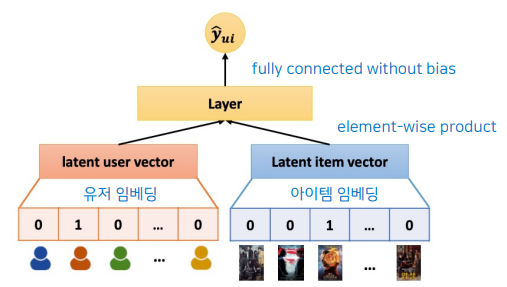

### Rating Data

user one-hot vector와 item one-hot vector는 R에 존재하는 데이터만 활용

input = R에서 존재하는 데이터만 활용 (왜? R에서 존재하는 데이터만 활용하면 결국 user one-hot vector * Latent user vector, item one-hot vector * Latent item vector 을 한것과 동일하게 됨)

Latent user vector = (user_num ,factor)

Latent item vector = (item_num ,factor)

element_wise_product = Latent user vector * Latent item vector

out = FC_layer(element_wise_product, 1)

output = Y_ui ~ out

최종 예측 값은 유저가 해당 영화에 줄 평점이 될 것 따라서 이를 바탕으로 영화 추천이 가능

In [ ]:
import os
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.backends.cudnn as cudnn

import pandas as pd
import scipy.sparse as sp
import warnings

warnings.filterwarnings(action='ignore')
%matplotlib inline

In [ ]:
movie_paths = '/content/drive/MyDrive/추천/data/movies/'

movie = pd.read_csv(movie_paths + "ratings.csv")
meta = pd.read_csv(movie_paths + 'movies_metadata.csv', low_memory=False)
meta = meta.rename(columns={'id':'movieId'})

In [ ]:
movie.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
meta.head()

,adult,belongs_to_collection,budget,genres,homepage,movieId,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
movie['movieId'] = movie['movieId'].astype(str)
meta['movieId'] = meta['movieId'].astype(str)

movie = pd.merge(movie, meta[['movieId', 'original_title']], on='movieId')
movie.head()

,userId,movieId,rating,timestamp,original_title
0,1,1371,2.5,1260759135,Rocky III
1,4,1371,4.0,949810302,Rocky III
2,7,1371,3.0,851869160,Rocky III
3,19,1371,4.0,855193404,Rocky III
4,21,1371,3.0,853852263,Rocky III


In [ ]:
df = movie.pivot_table(index='userId', columns = 'movieId', values = 'rating').fillna(0)
df.head()

movieId,100,100017,100032,100272,100450,101,101362,1018,101904,102,102165,1023,1024,103,103048,103210,103299,103502,103539,103688,103731,104,1040,104211,104241,104374,104863,1049,105,1050,1051,105121,105246,105254,105593,105763,1059,106417,107,107081,...,956,957,95744,95752,95949,95963,96,961,962,963,964,965,966,968,96821,97,97593,976,97936,97938,98,980,981,98122,982,98369,984,98491,986,98604,987,988,99,990,991,99106,992,994,996,99846
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# 환경설정
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')
print(DEVICE)

cuda


In [ ]:
BATCH_SIZE = 128
EPOCHS = 10

In [ ]:
R = df.iloc[:, : ].values

user_num = R.shape[0]
item_num = R.shape[1]

In [ ]:
features_idx = []
for i in range(user_num):
  for j in range(item_num):
    features_idx.append([i, j])

In [ ]:
features = np.transpose(R.nonzero()).tolist()

In [ ]:
labels = []

for i, j in features:
  labels.append(R[i, j])

In [ ]:
class GMF(nn.Module):
  def __init__(self, user_num, item_num, factor_num):
      super(GMF, self).__init__()

      # 유저 임베딩
      self.user_embedding = nn.Embedding(user_num, factor_num)

      # 아이템 임베딩
      self.item_embedding = nn.Embedding(item_num, factor_num)

      # FC
      self.FC_layer = nn.Sequential(
          nn.Linear(factor_num, 1)
      )
      self._init_weight_()

  def _init_weight_(self):
      # weight 초기화
      nn.init.normal_(self.user_embedding.weight, std=0.01)
      nn.init.normal_(self.item_embedding.weight, std=0.01)
      for m in self.FC_layer:
          if isinstance(m, nn.Linear):
              nn.init.xavier_uniform_(m.weight)

  def forward(self, user, item):
      user_embedding = self.user_embedding(user)
      item_embedding = self.item_embedding(item)

      element_wise_product = (user_embedding * item_embedding)

      out = self.FC_layer(element_wise_product)
      out = out.view(-1, 1)

      return out

In [ ]:
model = GMF(user_num = user_num, item_num = item_num, factor_num = 20).to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
class NCFData(data.Dataset):
    def __init__(self, features, labels = None):
        super(NCFData, self).__init__()
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):

      if self.labels is not None:
        user = self.features[idx][0]
        item = self.features[idx][1]
        label = self.labels[idx]

        return user, item, label

      else: 
        user = self.features[idx][0]
        item = self.features[idx][1]
        return user, item

In [ ]:
def train(model, train_loader):
  model.train()
  train_loss = 0
  for user, item, label in train_loader:
    user = user.to(DEVICE)
    item = item.to(DEVICE)
    label = label.float().to(DEVICE)
    optimizer.zero_grad()
    output = model(user, item)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  train_loss /= len(train_loader)
  return train_loss

In [ ]:
def predict(model, loader):
  model.eval()
  result = []
  with torch.no_grad():
    for user, item in loader:
      user = user.to(DEVICE)
      item = item.to(DEVICE)
      output = model(user, item)
      result.append(output.view(-1))

  return result

In [ ]:
train_dataset = NCFData(features, labels)
train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE)

for epoch in range(1, EPOCHS + 1):
  train_loss = train(model, train_loader)
  print(f"\n[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}")


[EPOCH: 1], 	Train Loss: 5.3773

[EPOCH: 2], 	Train Loss: 1.2619

[EPOCH: 3], 	Train Loss: 1.1715

[EPOCH: 4], 	Train Loss: 1.0327

[EPOCH: 5], 	Train Loss: 1.0122

[EPOCH: 6], 	Train Loss: 1.0085

[EPOCH: 7], 	Train Loss: 1.0077

[EPOCH: 8], 	Train Loss: 1.0085

[EPOCH: 9], 	Train Loss: 1.0105

[EPOCH: 10], 	Train Loss: 1.0097


In [ ]:
dataset = NCFData(features_idx)
loader = data.DataLoader(dataset, batch_size = BATCH_SIZE)
pred = predict(model, loader)
pred = torch.cat(pred).view(user_num, item_num)

In [ ]:
pred.shape

torch.Size([671, 2830])

In [ ]:
pred

tensor([[3.7138, 3.6987, 3.2571,  ..., 3.6739, 3.8039, 3.3279],
        [3.6944, 3.6226, 3.2220,  ..., 3.5323, 3.7053, 3.3520],
        [3.6992, 3.6691, 3.2339,  ..., 3.7036, 3.7126, 3.3699],
        ...,
        [3.4746, 3.4848, 3.2166,  ..., 3.5475, 3.4125, 3.2990],
        [3.5124, 3.9856, 3.1557,  ..., 3.7447, 3.9399, 3.3669],
        [3.8064, 3.9688, 3.2248,  ..., 3.8354, 4.0464, 3.3846]],
       device='cuda:0')

In [ ]:
R.shape

(671, 2830)

In [ ]:
R

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
_, idx =  torch.topk(pred, k = 10, dim = 1)

In [ ]:
pred[0, 168]

tensor(3.7009, device='cuda:0')

In [ ]:
R[0, 168]

2.5

데이터의 양이 적고 매우 Sparse한 형태의 데이터이기 때문에 모델의 성능이 매우 좋지 않은 것으로 생각된다.

### Watching Data

user one-hot vector와 item one-hot vector는 R에 존재하는 데이터만 활용

input = R에서 존재하는 데이터만 활용 (왜? R에서 존재하는 데이터만 활용하면 결국 user one-hot vector * Latent user vector, item one-hot vector * Latent item vector 을 한것과 동일하게 됨)

Latent user vector = (user_num ,factor)

Latent item vector = (item_num ,factor)

element_wise_product = Latent user vector * Latent item vector

out = FC_layer(element_wise_product, 1)

output = Y_ui ~ out

최종 예측 값은 유저가 해당 영화를 볼 확률이 될 것 따라서 이를 바탕으로 영화 추천이 가능

In [ ]:
import os
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.backends.cudnn as cudnn

import pandas as pd
import scipy.sparse as sp
import warnings

warnings.filterwarnings(action='ignore')
%matplotlib inline

In [ ]:
movie_paths = '/content/drive/MyDrive/추천/data/movies/'

movie = pd.read_csv(movie_paths + "ratings.csv")
meta = pd.read_csv(movie_paths + 'movies_metadata.csv', low_memory=False)
meta = meta.rename(columns={'id':'movieId'})

In [ ]:
movie.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
meta.head()

,adult,belongs_to_collection,budget,genres,homepage,movieId,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
movie['movieId'] = movie['movieId'].astype(str)
meta['movieId'] = meta['movieId'].astype(str)

movie = pd.merge(movie, meta[['movieId', 'original_title']], on='movieId')
movie['watching'] = 1
movie.head()

,userId,movieId,rating,timestamp,original_title,watching
0,1,1371,2.5,1260759135,Rocky III,1
1,4,1371,4.0,949810302,Rocky III,1
2,7,1371,3.0,851869160,Rocky III,1
3,19,1371,4.0,855193404,Rocky III,1
4,21,1371,3.0,853852263,Rocky III,1


In [ ]:
df = movie.pivot_table(index='userId', columns = 'movieId', values = 'watching').fillna(0)
df.head()

movieId,100,100017,100032,100272,100450,101,101362,1018,101904,102,102165,1023,1024,103,103048,103210,103299,103502,103539,103688,103731,104,1040,104211,104241,104374,104863,1049,105,1050,1051,105121,105246,105254,105593,105763,1059,106417,107,107081,...,956,957,95744,95752,95949,95963,96,961,962,963,964,965,966,968,96821,97,97593,976,97936,97938,98,980,981,98122,982,98369,984,98491,986,98604,987,988,99,990,991,99106,992,994,996,99846
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# 환경설정
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')
print(DEVICE)

cuda


In [ ]:
BATCH_SIZE = 128
EPOCHS = 10

In [ ]:
R = df.iloc[:, : ].values

user_num = R.shape[0]
item_num = R.shape[1]

In [ ]:
features_idx = []
for i in range(user_num):
  for j in range(item_num):
    features_idx.append([i, j])

In [ ]:
features = np.transpose(R.nonzero()).tolist()

In [ ]:
labels = []
for i, j in features_idx:
  labels.append(R[i, j])

In [ ]:
class GMF(nn.Module):
  def __init__(self, user_num, item_num, factor_num):
      super(GMF, self).__init__()

      # 유저 임베딩
      self.user_embedding = nn.Embedding(user_num, factor_num)

      # 아이템 임베딩
      self.item_embedding = nn.Embedding(item_num, factor_num)

      # FC
      self.FC_layer = nn.Sequential(
          nn.Linear(factor_num, 1),
          nn.Sigmoid()
      )
      self._init_weight_()

  def _init_weight_(self):
      # weight 초기화
      nn.init.xavier_uniform_(self.user_embedding.weight)
      nn.init.xavier_uniform_(self.item_embedding.weight)
      for m in self.FC_layer:
          if isinstance(m, nn.Linear):
              nn.init.xavier_uniform_(m.weight)

  def forward(self, user, item):
      user_embedding = self.user_embedding(user)
      item_embedding = self.item_embedding(item)

      element_wise_product = (user_embedding * item_embedding)

      out = self.FC_layer(element_wise_product)
      out = out.view(-1)

      return out

In [ ]:
model = GMF(user_num = user_num, item_num = item_num, factor_num = 20).to(DEVICE)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
class NCFData(data.Dataset):
    def __init__(self, features, labels = None):
        super(NCFData, self).__init__()
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):

      if self.labels is not None:
        user = self.features[idx][0]
        item = self.features[idx][1]
        label = self.labels[idx]

        return user, item, label

      else: 
        user = self.features[idx][0]
        item = self.features[idx][1]
        return user, item

In [ ]:
def train(model, train_loader):
  model.train()
  train_loss = 0
  for user, item, label in train_loader:
    user = user.to(DEVICE)
    item = item.to(DEVICE)
    label = label.float().to(DEVICE)
    optimizer.zero_grad()
    output = model(user, item)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  train_loss /= len(train_loader)
  return train_loss

In [ ]:
def predict(model, loader):
  model.eval()
  result = []
  with torch.no_grad():
    for user, item in loader:
      user = user.to(DEVICE)
      item = item.to(DEVICE)
      output = model(user, item)
      result.append(output.view(-1))

  return result

In [ ]:
train_dataset = NCFData(features_idx, labels)
train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE)

for epoch in range(1, EPOCHS + 1):
  train_loss = train(model, train_loader)
  print(f"\n[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}")


[EPOCH: 1], 	Train Loss: 0.0847

[EPOCH: 2], 	Train Loss: 0.0686

[EPOCH: 3], 	Train Loss: 0.0613

[EPOCH: 4], 	Train Loss: 0.0575

[EPOCH: 5], 	Train Loss: 0.0551

[EPOCH: 6], 	Train Loss: 0.0538

[EPOCH: 7], 	Train Loss: 0.0533

[EPOCH: 8], 	Train Loss: 0.0523

[EPOCH: 9], 	Train Loss: 0.0521

[EPOCH: 10], 	Train Loss: 0.0524


In [ ]:
dataset = NCFData(features_idx)
loader = data.DataLoader(dataset, batch_size = BATCH_SIZE)
pred = predict(model, loader)
pred = torch.cat(pred).view(user_num, item_num)

In [ ]:
pred.shape

torch.Size([671, 2830])

In [ ]:
pred

tensor([[1.2221e-04, 1.6810e-06, 1.4879e-06,  ..., 3.4820e-08, 5.8469e-06,
         6.4044e-08],
        [3.1098e-04, 1.9656e-05, 5.3910e-06,  ..., 1.5104e-03, 4.8453e-04,
         8.3329e-06],
        [9.7506e-04, 5.9095e-06, 3.1884e-05,  ..., 1.2293e-05, 7.2575e-04,
         4.8987e-07],
        ...,
        [6.0460e-03, 1.5687e-04, 1.0368e-04,  ..., 1.4828e-04, 1.5571e-05,
         2.2924e-05],
        [4.1949e-02, 8.2136e-06, 4.6239e-06,  ..., 2.6644e-03, 9.9316e-05,
         1.6770e-08],
        [5.2239e-03, 1.3984e-05, 7.0173e-06,  ..., 2.1940e-02, 7.5035e-05,
         2.9686e-07]], device='cuda:0')

In [ ]:
R.shape

(671, 2830)

In [ ]:
R

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
_, idx =  torch.topk(pred, k = 10, dim = 1)

In [ ]:
pred[0, 168]

tensor(0.0854, device='cuda:0')

In [ ]:
R[0, 168]

1.0

데이터의 양이 적고 매우 Sparse한 형태의 데이터이기 때문에 모델의 성능이 매우 좋지 않은 것으로 생각된다.

## MLP-based MF

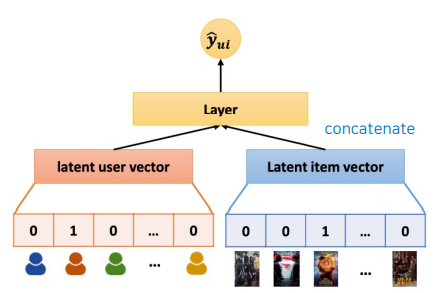

### Rating Data

user one-hot vector와 item one-hot vector는 R에 존재하는 데이터만 활용

input = R에서 존재하는 데이터만 활용 (왜? R에서 존재하는 데이터만 활용하면 결국 user one-hot vector * Latent user vector, item one-hot vector * Latent item vector 을 한것과 동일하게 됨)

Latent user vector = (user_num ,factor)

Latent item vector = (item_num ,factor)

concat_two_latent_vactors = concat(Latent user vector, Latent item vector)

output_MLP = MLP_layer(concat_two_latent_vactors)

out = FC_layer(output_MLP, 1)

output = Y_ui ~ out

최종 예측 값은 유저가 해당 영화에 줄 평점이 될 것 따라서 이를 바탕으로 영화 추천이 가능

In [ ]:
import os
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.backends.cudnn as cudnn

import pandas as pd
import scipy.sparse as sp
import warnings

warnings.filterwarnings(action='ignore')
%matplotlib inline

In [ ]:
movie_paths = '/content/drive/MyDrive/추천/data/movies/'

movie = pd.read_csv(movie_paths + "ratings.csv")
meta = pd.read_csv(movie_paths + 'movies_metadata.csv', low_memory=False)
meta = meta.rename(columns={'id':'movieId'})

In [ ]:
movie.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
meta.head()

,adult,belongs_to_collection,budget,genres,homepage,movieId,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
movie['movieId'] = movie['movieId'].astype(str)
meta['movieId'] = meta['movieId'].astype(str)

movie = pd.merge(movie, meta[['movieId', 'original_title']], on='movieId')
movie.head()

,userId,movieId,rating,timestamp,original_title
0,1,1371,2.5,1260759135,Rocky III
1,4,1371,4.0,949810302,Rocky III
2,7,1371,3.0,851869160,Rocky III
3,19,1371,4.0,855193404,Rocky III
4,21,1371,3.0,853852263,Rocky III


In [ ]:
df = movie.pivot_table(index='userId', columns = 'movieId', values = 'rating').fillna(0)
df.head()

movieId,100,100017,100032,100272,100450,101,101362,1018,101904,102,102165,1023,1024,103,103048,103210,103299,103502,103539,103688,103731,104,1040,104211,104241,104374,104863,1049,105,1050,1051,105121,105246,105254,105593,105763,1059,106417,107,107081,...,956,957,95744,95752,95949,95963,96,961,962,963,964,965,966,968,96821,97,97593,976,97936,97938,98,980,981,98122,982,98369,984,98491,986,98604,987,988,99,990,991,99106,992,994,996,99846
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# 환경설정
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')
print(DEVICE)

cpu


In [ ]:
BATCH_SIZE = 128
EPOCHS = 10

In [ ]:
R = df.iloc[:, : ].values

user_num = R.shape[0]
item_num = R.shape[1]

In [ ]:
features_idx = []
for i in range(user_num):
  for j in range(item_num):
    features_idx.append([i, j])

In [ ]:
features = np.transpose(R.nonzero()).tolist()

In [ ]:
labels = []

for i, j in features:
  labels.append(R[i, j])

In [ ]:
class MLP_MF(nn.Module):
  def __init__(self, user_num, item_num, factor_num, num_layers = 3):
      super(MLP_MF, self).__init__()

      # 유저 임베딩
      self.user_embedding = nn.Embedding(user_num, factor_num)

      # 아이템 임베딩
      self.item_embedding = nn.Embedding(item_num, factor_num)

      MLP_modules = []
      input_size = factor_num * 2
      for i in range(num_layers):
        MLP_modules.append(nn.Linear(input_size, input_size // 2))
        MLP_modules.append(nn.ReLU())
        input_size //=  2
      self.MLP_layers = nn.Sequential(*MLP_modules)

      # FC
      self.FC_layer = nn.Sequential(
          nn.Linear(input_size, 1)
      )
      self._init_weight_()

  def _init_weight_(self):
      # weight 초기화
      nn.init.xavier_uniform_(self.user_embedding.weight)
      nn.init.xavier_uniform_(self.item_embedding.weight)
      for m in self.MLP_layers:
          if isinstance(m, nn.Linear):
              nn.init.xavier_uniform_(m.weight)

      for m in self.FC_layer:
          if isinstance(m, nn.Linear):
              nn.init.xavier_uniform_(m.weight)

  def forward(self, user, item):
      user_embedding = self.user_embedding(user)
      item_embedding = self.item_embedding(item)

      concat_two_latent_vactors = torch.cat((user_embedding, item_embedding), -1)
      output_MLP = self.MLP_layers(concat_two_latent_vactors)

      out = self.FC_layer(output_MLP)
      out = out.view(-1)

      return out

In [ ]:
model = MLP_MF(user_num = user_num, item_num = item_num, factor_num = 20).to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
class NCFData(data.Dataset):
    def __init__(self, features, labels = None):
        super(NCFData, self).__init__()
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):

      if self.labels is not None:
        user = self.features[idx][0]
        item = self.features[idx][1]
        label = self.labels[idx]

        return user, item, label

      else: 
        user = self.features[idx][0]
        item = self.features[idx][1]
        return user, item

In [ ]:
def train(model, train_loader):
  model.train()
  train_loss = 0
  for user, item, label in train_loader:
    user = user.to(DEVICE)
    item = item.to(DEVICE)
    label = label.float().to(DEVICE)
    optimizer.zero_grad()
    output = model(user, item)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  train_loss /= len(train_loader)
  return train_loss

In [ ]:
def predict(model, loader):
  model.eval()
  result = []
  with torch.no_grad():
    for user, item in loader:
      user = user.to(DEVICE)
      item = item.to(DEVICE)
      output = model(user, item)
      result.append(output.view(-1))

  return result

In [ ]:
train_dataset = NCFData(features, labels)
train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE)

for epoch in range(1, EPOCHS + 1):
  train_loss = train(model, train_loader)
  print(f"\n[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}")


[EPOCH: 1], 	Train Loss: 1.8819

[EPOCH: 2], 	Train Loss: 0.9376

[EPOCH: 3], 	Train Loss: 1.0602

[EPOCH: 4], 	Train Loss: 0.8491

[EPOCH: 5], 	Train Loss: 0.8045

[EPOCH: 6], 	Train Loss: 0.7997

[EPOCH: 7], 	Train Loss: 0.7977

[EPOCH: 8], 	Train Loss: 0.7798

[EPOCH: 9], 	Train Loss: 0.7641

[EPOCH: 10], 	Train Loss: 0.7298


In [ ]:
dataset = NCFData(features_idx)
loader = data.DataLoader(dataset, batch_size = BATCH_SIZE)
pred = predict(model, loader)
pred = torch.cat(pred).view(user_num, item_num)

In [ ]:
pred.shape

torch.Size([671, 2830])

In [ ]:
pred

tensor([[3.1145, 2.1494, 2.2385,  ..., 3.7837, 2.7288, 2.3369],
        [3.1839, 3.1165, 3.1165,  ..., 3.8756, 3.4651, 3.4379],
        [3.1165, 3.1165, 3.1165,  ..., 3.7639, 3.3615, 3.2690],
        ...,
        [3.4907, 2.5599, 3.0067,  ..., 4.2342, 3.6537, 3.6173],
        [3.2756, 3.1165, 3.4353,  ..., 3.9577, 3.4664, 3.4700],
        [3.3810, 2.4370, 2.7961,  ..., 4.1518, 3.3872, 3.2096]])

In [ ]:
R.shape

(671, 2830)

In [ ]:
R

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
_, idx =  torch.topk(pred, k = 10, dim = 1)

In [ ]:
pred[0, 168]

tensor(2.1373)

In [ ]:
R[0, 168]

2.5

데이터의 양이 적고 매우 Sparse한 형태의 데이터이기 때문에 모델의 성능이 매우 좋지 않은 것으로 생각된다.

### Watching Data

user one-hot vector와 item one-hot vector는 R에 존재하는 데이터만 활용

input = R에서 존재하는 데이터만 활용 (왜? R에서 존재하는 데이터만 활용하면 결국 user one-hot vector * Latent user vector, item one-hot vector * Latent item vector 을 한것과 동일하게 됨)

Latent user vector = (user_num ,factor)

Latent item vector = (item_num ,factor)

concat_two_latent_vactors = concat(Latent user vector, Latent item vector)

output_MLP = MLP_layer(concat_two_latent_vactors)

out = FC_layer(output_MLP, 1)

output = Y_ui ~ out

최종 예측 값은 유저가 해당 영화를 볼 확률이 될 것 따라서 이를 바탕으로 영화 추천이 가능

In [ ]:
import os
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.backends.cudnn as cudnn

import pandas as pd
import scipy.sparse as sp
import warnings

warnings.filterwarnings(action='ignore')
%matplotlib inline

In [ ]:
movie_paths = '/content/drive/MyDrive/추천/data/movies/'

movie = pd.read_csv(movie_paths + "ratings.csv")
meta = pd.read_csv(movie_paths + 'movies_metadata.csv', low_memory=False)
meta = meta.rename(columns={'id':'movieId'})

In [ ]:
movie.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
meta.head()

,adult,belongs_to_collection,budget,genres,homepage,movieId,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
movie['movieId'] = movie['movieId'].astype(str)
meta['movieId'] = meta['movieId'].astype(str)

movie = pd.merge(movie, meta[['movieId', 'original_title']], on='movieId')
movie['watching'] = 1
movie.head()

,userId,movieId,rating,timestamp,original_title,watching
0,1,1371,2.5,1260759135,Rocky III,1
1,4,1371,4.0,949810302,Rocky III,1
2,7,1371,3.0,851869160,Rocky III,1
3,19,1371,4.0,855193404,Rocky III,1
4,21,1371,3.0,853852263,Rocky III,1


In [ ]:
df = movie.pivot_table(index='userId', columns = 'movieId', values = 'watching').fillna(0)
df.head()

movieId,100,100017,100032,100272,100450,101,101362,1018,101904,102,102165,1023,1024,103,103048,103210,103299,103502,103539,103688,103731,104,1040,104211,104241,104374,104863,1049,105,1050,1051,105121,105246,105254,105593,105763,1059,106417,107,107081,...,956,957,95744,95752,95949,95963,96,961,962,963,964,965,966,968,96821,97,97593,976,97936,97938,98,980,981,98122,982,98369,984,98491,986,98604,987,988,99,990,991,99106,992,994,996,99846
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# 환경설정
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')
print(DEVICE)

cuda


In [ ]:
BATCH_SIZE = 128
EPOCHS = 10

In [ ]:
R = df.iloc[:, : ].values

user_num = R.shape[0]
item_num = R.shape[1]

In [ ]:
features_idx = []
for i in range(user_num):
  for j in range(item_num):
    features_idx.append([i, j])

In [ ]:
features = np.transpose(R.nonzero()).tolist()

In [ ]:
labels = []
for i, j in features_idx:
  labels.append(R[i, j])

In [ ]:
class MLP_MF(nn.Module):
  def __init__(self, user_num, item_num, factor_num, num_layers = 3):
      super(MLP_MF, self).__init__()

      # 유저 임베딩
      self.user_embedding = nn.Embedding(user_num, factor_num)

      # 아이템 임베딩
      self.item_embedding = nn.Embedding(item_num, factor_num)

      MLP_modules = []
      input_size = factor_num * 2
      for i in range(num_layers):
        MLP_modules.append(nn.Linear(input_size, input_size // 2))
        MLP_modules.append(nn.ReLU())
        input_size //=  2
      self.MLP_layers = nn.Sequential(*MLP_modules)

      # FC
      self.FC_layer = nn.Sequential(
          nn.Linear(input_size, 1),
          nn.Sigmoid()
      )
      self._init_weight_()

  def _init_weight_(self):
      # weight 초기화
      nn.init.normal_(self.user_embedding.weight, std=0.01)
      nn.init.normal_(self.item_embedding.weight, std=0.01)
      for m in self.MLP_layers:
          if isinstance(m, nn.Linear):
              nn.init.xavier_uniform_(m.weight)

      for m in self.FC_layer:
          if isinstance(m, nn.Linear):
              nn.init.xavier_uniform_(m.weight)

  def forward(self, user, item):
      user_embedding = self.user_embedding(user)
      item_embedding = self.item_embedding(item)

      concat_two_latent_vactors = torch.cat((user_embedding, item_embedding), -1)
      output_MLP = self.MLP_layers(concat_two_latent_vactors)

      out = self.FC_layer(output_MLP)
      out = out.view(-1)

      return out

In [ ]:
model = MLP_MF(user_num = user_num, item_num = item_num, factor_num = 20).to(DEVICE)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
class NCFData(data.Dataset):
    def __init__(self, features, labels = None):
        super(NCFData, self).__init__()
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):

      if self.labels is not None:
        user = self.features[idx][0]
        item = self.features[idx][1]
        label = self.labels[idx]

        return user, item, label

      else: 
        user = self.features[idx][0]
        item = self.features[idx][1]
        return user, item

In [ ]:
def train(model, train_loader):
  model.train()
  train_loss = 0
  for user, item, label in train_loader:
    user = user.to(DEVICE)
    item = item.to(DEVICE)
    label = label.float().to(DEVICE)
    optimizer.zero_grad()
    output = model(user, item)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  train_loss /= len(train_loader)
  return train_loss

In [ ]:
def predict(model, loader):
  model.eval()
  result = []
  with torch.no_grad():
    for user, item in loader:
      user = user.to(DEVICE)
      item = item.to(DEVICE)
      output = model(user, item)
      result.append(output.view(-1))

  return result

In [ ]:
train_dataset = NCFData(features_idx, labels)
train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle= True)

for epoch in range(1, EPOCHS + 1):
  train_loss = train(model, train_loader)
  print(f"\n[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}")


[EPOCH: 1], 	Train Loss: 0.0769

[EPOCH: 2], 	Train Loss: 0.0710

[EPOCH: 3], 	Train Loss: 0.0683

[EPOCH: 4], 	Train Loss: 0.0661

[EPOCH: 5], 	Train Loss: 0.0646

[EPOCH: 6], 	Train Loss: 0.0635

[EPOCH: 7], 	Train Loss: 0.0628

[EPOCH: 8], 	Train Loss: 0.0626

[EPOCH: 9], 	Train Loss: 0.0623

[EPOCH: 10], 	Train Loss: 0.0618


In [ ]:
dataset = NCFData(features_idx)
loader = data.DataLoader(dataset, batch_size = BATCH_SIZE)
pred = predict(model, loader)
pred = torch.cat(pred).view(user_num, item_num)

In [ ]:
pred.shape

torch.Size([671, 2830])

In [ ]:
pred

tensor([[1.2030e-03, 4.7638e-05, 1.4715e-05,  ..., 1.9373e-03, 4.8133e-04,
         5.9796e-05],
        [5.5750e-02, 3.0418e-05, 3.8340e-04,  ..., 8.8968e-04, 2.2465e-02,
         2.4509e-04],
        [6.5578e-03, 2.1458e-05, 8.0642e-05,  ..., 3.1768e-03, 2.6323e-03,
         4.9615e-05],
        ...,
        [9.7481e-04, 7.6924e-04, 1.1466e-04,  ..., 1.0437e-02, 3.4021e-04,
         7.0018e-04],
        [4.2896e-03, 2.2925e-05, 5.2631e-05,  ..., 5.7240e-03, 1.7195e-03,
         7.3105e-05],
        [2.9317e-03, 2.0208e-04, 2.3867e-04,  ..., 3.2058e-02, 1.0245e-03,
         4.6713e-04]], device='cuda:0')

In [ ]:
R.shape

(671, 2830)

In [ ]:
R

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
_, idx =  torch.topk(pred, k = 10, dim = 1)

In [ ]:
pred[0, 168]

tensor(0.0074, device='cuda:0')

In [ ]:
R[0, 168]

1.0

데이터의 양이 적고 매우 Sparse한 형태의 데이터이기 때문에 모델의 성능이 매우 좋지 않은 것으로 생각된다.

## NCF

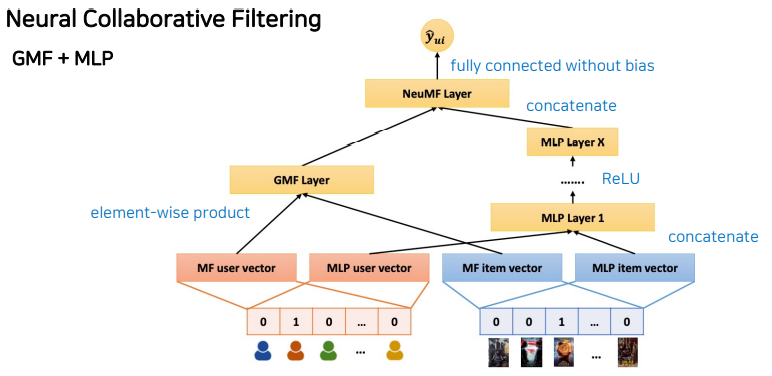

### Rating Data

user one-hot vector와 item one-hot vector는 R에 존재하는 데이터만 활용

input = R에서 존재하는 데이터만 활용 (왜? R에서 존재하는 데이터만 활용하면 결국 user one-hot vector * Latent user vector, item one-hot vector * Latent item vector 을 한것과 동일하게 됨)

GMF Latent user vector = (user_num ,factor)

GMF Latent item vector = (item_num ,factor)

MLP Latent user vector = (user_num ,factor)

MLP Latent item vector = (item_num ,factor)

output_GMF = GMF Latent user vector * GMF Latent item vector

MLP_concat_two_latent_vactors = concat(MLP Latent user vector, MLP Latent item vector)

output_MLP = MLP_layer(MLP_concat_two_latent_vactors)

output = concat(output_GMF, output_MLP)

out = FC_layer(output, 1)

output = Y_ui ~ out

최종 예측 값은 유저가 해당 영화에 줄 평점이 될 것 따라서 이를 바탕으로 영화 추천이 가능

In [ ]:
import os
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.backends.cudnn as cudnn

import pandas as pd
import scipy.sparse as sp
import warnings

warnings.filterwarnings(action='ignore')
%matplotlib inline

In [ ]:
movie_paths = '/content/drive/MyDrive/추천/data/movies/'

movie = pd.read_csv(movie_paths + "ratings.csv")
meta = pd.read_csv(movie_paths + 'movies_metadata.csv', low_memory=False)
meta = meta.rename(columns={'id':'movieId'})

In [ ]:
movie.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
meta.head()

,adult,belongs_to_collection,budget,genres,homepage,movieId,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
movie['movieId'] = movie['movieId'].astype(str)
meta['movieId'] = meta['movieId'].astype(str)

movie = pd.merge(movie, meta[['movieId', 'original_title']], on='movieId')
movie.head()

,userId,movieId,rating,timestamp,original_title
0,1,1371,2.5,1260759135,Rocky III
1,4,1371,4.0,949810302,Rocky III
2,7,1371,3.0,851869160,Rocky III
3,19,1371,4.0,855193404,Rocky III
4,21,1371,3.0,853852263,Rocky III


In [ ]:
df = movie.pivot_table(index='userId', columns = 'movieId', values = 'rating').fillna(0)
df.head()

movieId,100,100017,100032,100272,100450,101,101362,1018,101904,102,102165,1023,1024,103,103048,103210,103299,103502,103539,103688,103731,104,1040,104211,104241,104374,104863,1049,105,1050,1051,105121,105246,105254,105593,105763,1059,106417,107,107081,...,956,957,95744,95752,95949,95963,96,961,962,963,964,965,966,968,96821,97,97593,976,97936,97938,98,980,981,98122,982,98369,984,98491,986,98604,987,988,99,990,991,99106,992,994,996,99846
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# 환경설정
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')
print(DEVICE)

cpu


In [ ]:
BATCH_SIZE = 128
EPOCHS = 10

In [ ]:
R = df.iloc[:, : ].values

user_num = R.shape[0]
item_num = R.shape[1]

In [ ]:
features_idx = []
for i in range(user_num):
  for j in range(item_num):
    features_idx.append([i, j])

In [ ]:
features = np.transpose(R.nonzero()).tolist()

In [ ]:
labels = []

for i, j in features:
  labels.append(R[i, j])

In [ ]:
class GMF_and_MLP(nn.Module):
  def __init__(self, user_num, item_num, factor_num, num_layers = 3):
      super(GMF_and_MLP, self).__init__()

      # GMF 임베딩
      self.GMF_user_embedding = nn.Embedding(user_num, factor_num)
      self.GMF_item_embedding = nn.Embedding(item_num, factor_num)

      # MLP 임베딩
      self.MLP_user_embedding = nn.Embedding(user_num, factor_num)
      self.MLP_item_embedding = nn.Embedding(item_num, factor_num)

      MLP_modules = []
      input_size = factor_num * 2
      for i in range(num_layers):
        MLP_modules.append(nn.Linear(input_size, input_size // 2))
        MLP_modules.append(nn.ReLU())
        input_size //=  2
      self.MLP_layers = nn.Sequential(*MLP_modules)

      # FC
      self.FC_layer = nn.Sequential(
          nn.Linear(factor_num + input_size, 1)
      )
      self._init_weight_()

  def _init_weight_(self):
      # weight 초기화
      nn.init.normal_(self.GMF_user_embedding.weight, std=0.01)
      nn.init.normal_(self.GMF_item_embedding.weight, std=0.01)
      nn.init.normal_(self.MLP_user_embedding.weight, std=0.01)
      nn.init.normal_(self.MLP_item_embedding.weight, std=0.01)

      for m in self.MLP_layers:
          if isinstance(m, nn.Linear):
              nn.init.xavier_uniform_(m.weight)

      for m in self.FC_layer:
          if isinstance(m, nn.Linear):
              nn.init.xavier_uniform_(m.weight)

  def forward(self, user, item):
      GMF_user_embedding = self.GMF_user_embedding(user)
      GMF_item_embedding = self.GMF_item_embedding(item)

      output_GMF = (GMF_user_embedding * GMF_item_embedding)

      MLP_user_embedding = self.MLP_user_embedding(user)
      MLP_item_embedding = self.MLP_item_embedding(item)

      concat_two_latent_vactors = torch.cat((MLP_user_embedding, MLP_item_embedding), -1)
      output_MLP = self.MLP_layers(concat_two_latent_vactors)

      concat_GMF_MLP = torch.cat((output_GMF, output_MLP), -1)

      out = self.FC_layer(concat_GMF_MLP)
      out = out.view(-1)

      return out

In [ ]:
model = GMF_and_MLP(user_num = user_num, item_num = item_num, factor_num = 20).to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
class NCFData(data.Dataset):
    def __init__(self, features, labels = None):
        super(NCFData, self).__init__()
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):

      if self.labels is not None:
        user = self.features[idx][0]
        item = self.features[idx][1]
        label = self.labels[idx]

        return user, item, label

      else: 
        user = self.features[idx][0]
        item = self.features[idx][1]
        return user, item

In [ ]:
def train(model, train_loader):
  model.train()
  train_loss = 0
  for user, item, label in train_loader:
    user = user.to(DEVICE)
    item = item.to(DEVICE)
    label = label.float().to(DEVICE)
    optimizer.zero_grad()
    output = model(user, item)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  train_loss /= len(train_loader)
  return train_loss

In [ ]:
def predict(model, loader):
  model.eval()
  result = []
  with torch.no_grad():
    for user, item in loader:
      user = user.to(DEVICE)
      item = item.to(DEVICE)
      output = model(user, item)
      result.append(output.view(-1))

  return result

In [ ]:
train_dataset = NCFData(features, labels)
train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE)

for epoch in range(1, EPOCHS + 1):
  train_loss = train(model, train_loader)
  print(f"\n[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}")


[EPOCH: 1], 	Train Loss: 1.4863

[EPOCH: 2], 	Train Loss: 0.8686

[EPOCH: 3], 	Train Loss: 0.8743

[EPOCH: 4], 	Train Loss: 0.6191

[EPOCH: 5], 	Train Loss: 0.4452

[EPOCH: 6], 	Train Loss: 0.3894

[EPOCH: 7], 	Train Loss: 0.3588

[EPOCH: 8], 	Train Loss: 0.3374

[EPOCH: 9], 	Train Loss: 0.3164

[EPOCH: 10], 	Train Loss: 0.3157


In [ ]:
dataset = NCFData(features_idx)
loader = data.DataLoader(dataset, batch_size = BATCH_SIZE)
pred = predict(model, loader)
pred = torch.cat(pred).view(user_num, item_num)

In [ ]:
pred.shape

torch.Size([671, 2830])

In [ ]:
pred

tensor([[3.3646, 2.9302, 3.2288,  ..., 3.2210, 1.9280, 2.6346],
        [4.0337, 2.3965, 3.0552,  ..., 3.1314, 2.8062, 3.7697],
        [3.6591, 2.5289, 2.9345,  ..., 4.2492, 3.9218, 3.8126],
        ...,
        [1.7532, 2.7788, 3.7487,  ..., 4.1492, 3.3240, 2.7195],
        [3.2449, 3.0934, 3.4631,  ..., 4.0583, 3.6396, 3.5495],
        [3.5456, 2.5031, 3.6707,  ..., 3.5429, 3.6101, 3.9073]])

In [ ]:
R.shape

(671, 2830)

In [ ]:
R

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
_, idx =  torch.topk(pred, k = 10, dim = 1)

In [ ]:
pred[0, 168]

tensor(1.6956)

In [ ]:
R[0, 168]

2.5

데이터의 양이 적고 매우 Sparse한 형태의 데이터이기 때문에 모델의 성능이 매우 좋지 않은 것으로 생각된다.

### Watching Data

user one-hot vector와 item one-hot vector는 R에 존재하는 데이터만 활용

input = R에서 존재하는 데이터만 활용 (왜? R에서 존재하는 데이터만 활용하면 결국 user one-hot vector * Latent user vector, item one-hot vector * Latent item vector 을 한것과 동일하게 됨)

GMF Latent user vector = (user_num ,factor)

GMF Latent item vector = (item_num ,factor)

MLP Latent user vector = (user_num ,factor)

MLP Latent item vector = (item_num ,factor)

output_GMF = GMF Latent user vector * GMF Latent item vector

MLP_concat_two_latent_vactors = concat(MLP Latent user vector, MLP Latent item vector)

output_MLP = MLP_layer(MLP_concat_two_latent_vactors)

output = concat(output_GMF, output_MLP)

out = FC_layer(output, 1)

output = Y_ui ~ out

최종 예측 값은 유저가 해당 영화에 줄 평점이 될 것 따라서 이를 바탕으로 영화 추천이 가능

In [ ]:
import os
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.backends.cudnn as cudnn

import pandas as pd
import scipy.sparse as sp
import warnings

warnings.filterwarnings(action='ignore')
%matplotlib inline

In [ ]:
movie_paths = '/content/drive/MyDrive/추천/data/movies/'

movie = pd.read_csv(movie_paths + "ratings.csv")
meta = pd.read_csv(movie_paths + 'movies_metadata.csv', low_memory=False)
meta = meta.rename(columns={'id':'movieId'})

In [ ]:
movie.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
meta.head()

,adult,belongs_to_collection,budget,genres,homepage,movieId,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
movie['movieId'] = movie['movieId'].astype(str)
meta['movieId'] = meta['movieId'].astype(str)

movie = pd.merge(movie, meta[['movieId', 'original_title']], on='movieId')
movie['watching'] = 1
movie.head()

,userId,movieId,rating,timestamp,original_title,watching
0,1,1371,2.5,1260759135,Rocky III,1
1,4,1371,4.0,949810302,Rocky III,1
2,7,1371,3.0,851869160,Rocky III,1
3,19,1371,4.0,855193404,Rocky III,1
4,21,1371,3.0,853852263,Rocky III,1


In [ ]:
df = movie.pivot_table(index='userId', columns = 'movieId', values = 'watching').fillna(0)
df.head()

movieId,100,100017,100032,100272,100450,101,101362,1018,101904,102,102165,1023,1024,103,103048,103210,103299,103502,103539,103688,103731,104,1040,104211,104241,104374,104863,1049,105,1050,1051,105121,105246,105254,105593,105763,1059,106417,107,107081,...,956,957,95744,95752,95949,95963,96,961,962,963,964,965,966,968,96821,97,97593,976,97936,97938,98,980,981,98122,982,98369,984,98491,986,98604,987,988,99,990,991,99106,992,994,996,99846
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# 환경설정
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')
print(DEVICE)

cuda


In [ ]:
BATCH_SIZE = 128
EPOCHS = 10

In [ ]:
R = df.iloc[:, : ].values

user_num = R.shape[0]
item_num = R.shape[1]

In [ ]:
features_idx = []
for i in range(user_num):
  for j in range(item_num):
    features_idx.append([i, j])

In [ ]:
features = np.transpose(R.nonzero()).tolist()

In [ ]:
labels = []

for i, j in features_idx:
  labels.append(R[i, j])

In [ ]:
class GMF_and_MLP(nn.Module):
  def __init__(self, user_num, item_num, factor_num, num_layers = 3):
      super(GMF_and_MLP, self).__init__()

      # GMF 임베딩
      self.GMF_user_embedding = nn.Embedding(user_num, factor_num)
      self.GMF_item_embedding = nn.Embedding(item_num, factor_num)

      # MLP 임베딩
      self.MLP_user_embedding = nn.Embedding(user_num, factor_num)
      self.MLP_item_embedding = nn.Embedding(item_num, factor_num)

      MLP_modules = []
      input_size = factor_num * 2
      for i in range(num_layers):
        MLP_modules.append(nn.Linear(input_size, input_size // 2))
        MLP_modules.append(nn.ReLU())
        input_size //=  2
      self.MLP_layers = nn.Sequential(*MLP_modules)

      # FC
      self.FC_layer = nn.Sequential(
          nn.Linear(factor_num + input_size, 1),
          nn.Sigmoid()
      )
      self._init_weight_()

  def _init_weight_(self):
      # weight 초기화
      nn.init.normal_(self.GMF_user_embedding.weight, std=0.01)
      nn.init.normal_(self.GMF_item_embedding.weight, std=0.01)
      nn.init.normal_(self.MLP_user_embedding.weight, std=0.01)
      nn.init.normal_(self.MLP_item_embedding.weight, std=0.01)

      for m in self.MLP_layers:
          if isinstance(m, nn.Linear):
              nn.init.xavier_uniform_(m.weight)

      for m in self.FC_layer:
          if isinstance(m, nn.Linear):
              nn.init.xavier_uniform_(m.weight)

  def forward(self, user, item):
      GMF_user_embedding = self.GMF_user_embedding(user)
      GMF_item_embedding = self.GMF_item_embedding(item)

      output_GMF = (GMF_user_embedding * GMF_item_embedding)

      MLP_user_embedding = self.MLP_user_embedding(user)
      MLP_item_embedding = self.MLP_item_embedding(item)

      concat_two_latent_vactors = torch.cat((MLP_user_embedding, MLP_item_embedding), -1)
      output_MLP = self.MLP_layers(concat_two_latent_vactors)

      concat_GMF_MLP = torch.cat((output_GMF, output_MLP), -1)

      out = self.FC_layer(concat_GMF_MLP)
      out = out.view(-1)

      return out

In [ ]:
model = GMF_and_MLP(user_num = user_num, item_num = item_num, factor_num = 20).to(DEVICE)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
class NCFData(data.Dataset):
    def __init__(self, features, labels = None):
        super(NCFData, self).__init__()
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):

      if self.labels is not None:
        user = self.features[idx][0]
        item = self.features[idx][1]
        label = self.labels[idx]

        return user, item, label

      else: 
        user = self.features[idx][0]
        item = self.features[idx][1]
        return user, item

In [ ]:
def train(model, train_loader):
  model.train()
  train_loss = 0
  for user, item, label in train_loader:
    user = user.to(DEVICE)
    item = item.to(DEVICE)
    label = label.float().to(DEVICE)
    optimizer.zero_grad()
    output = model(user, item)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  train_loss /= len(train_loader)
  return train_loss

In [ ]:
def predict(model, loader):
  model.eval()
  result = []
  with torch.no_grad():
    for user, item in loader:
      user = user.to(DEVICE)
      item = item.to(DEVICE)
      output = model(user, item)
      result.append(output.view(-1))

  return result

In [ ]:
train_dataset = NCFData(features_idx, labels)
train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle= True)

for epoch in range(1, EPOCHS + 1):
  train_loss = train(model, train_loader)
  print(f"\n[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}")


[EPOCH: 1], 	Train Loss: 0.0743

[EPOCH: 2], 	Train Loss: 0.0636

[EPOCH: 3], 	Train Loss: 0.0603

[EPOCH: 4], 	Train Loss: 0.0589

[EPOCH: 5], 	Train Loss: 0.0583

[EPOCH: 6], 	Train Loss: 0.0579

[EPOCH: 7], 	Train Loss: 0.0578

[EPOCH: 8], 	Train Loss: 0.0575

[EPOCH: 9], 	Train Loss: 0.0576

[EPOCH: 10], 	Train Loss: 0.0577


In [ ]:
dataset = NCFData(features_idx)
loader = data.DataLoader(dataset, batch_size = BATCH_SIZE)
pred = predict(model, loader)
pred = torch.cat(pred).view(user_num, item_num)

In [ ]:
pred.shape

torch.Size([671, 2830])

In [ ]:
pred

tensor([[2.7552e-07, 7.1170e-11, 1.8879e-13,  ..., 1.5908e-06, 1.6034e-07,
         2.9589e-11],
        [6.1797e-07, 5.8171e-12, 1.0347e-13,  ..., 2.2148e-05, 1.8096e-08,
         2.5473e-13],
        [3.6389e-06, 8.1974e-08, 2.6040e-09,  ..., 1.0218e-05, 8.8486e-05,
         5.6360e-09],
        ...,
        [2.0834e-07, 4.3414e-09, 4.9481e-10,  ..., 2.9967e-05, 7.0031e-08,
         3.8819e-10],
        [2.1406e-04, 1.6129e-10, 3.2968e-10,  ..., 4.4024e-04, 2.2731e-06,
         4.9068e-12],
        [5.9553e-07, 1.2189e-09, 4.8112e-10,  ..., 3.4414e-04, 2.0893e-07,
         6.6648e-11]], device='cuda:0')

In [ ]:
R.shape

(671, 2830)

In [ ]:
R

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
_, idx =  torch.topk(pred, k = 10, dim = 1)

In [ ]:
pred[0, 168]

tensor(0.0227, device='cuda:0')

In [ ]:
R[0, 168]

1.0

데이터의 양이 적고 매우 Sparse한 형태의 데이터이기 때문에 모델의 성능이 매우 좋지 않은 것으로 생각된다.

# 데이터 출처
- https://www.kaggle.com/chocozzz/t-academy-recommendation2


# 참고자료

- https://developers.google.com/machine-learning/recommendation?hl=ko

- https://tacademy.skplanet.com/live/player/onlineLectureDetail.action?seq=194

- https://www.youtube.com/watch?v=1fhNX_JFaow

- https://brunch.co.kr/@kakao-it/72#comment

- https://www.youtube.com/watch?v=h6vePourB7E&list=LL&index=1&t=15s

- https://ratsgo.github.io/generative%20model/2018/01/27/VAE/

- https://github.com/GunhoChoi/PyTorch-FastCampus/blob/master/08_Autoencoder/3_Variational_Autoencoder.ipynb

- https://ko-kr.facebook.com/groups/TensorFlowKR/permalink/524873987853664/

- https://doheelab.github.io/recommender-system/ncf_mlp/